## Analysis on the initial state selection

### Hypothesis: Initial state selection affects the performance of the PbPI algorithm

#### Analysis method:

- Design a two sets of state pools with equal number of states
    - First, generate a large pool of states by letting the agent follow a random policy for 1000 steps; if an episode terminates while executing this number of actions, the environment is reset and the remaining actions are executed.
    - Afterwards, derive three sets of initial states by following the below approach:
        - From the initial pool of states, randomly sample 50 states to derive a initial state distribution of the pendulum angle skewed to right.
        - From the initial pool of states, randomly sample 50 states to derive a initial state distribution of the pendulum angle skewed to left.
        - From the initial pool of states, divide the captured pendulum angle (state) into 10 equidistant partitions and sample 4 states from each partition:
            - When partitioning the state pendulum angle state values, I define a upper and lower bounds on the pendulum angle as -45 degrees  (-0.77 rads) and + 45 degrees (+0.77 rads).
            - This is due to the assumption that once the pendulum exceeds these thresholds, the agent will not be able to balance the pendulum again regardless how large the magnitute of the force would be.

In [1]:
########################################
### importing the necessary packages ###
########################################

import gym
from gym import wrappers
import custom_cartpole  # custom cart-pole environment

import numpy as np
import pandas as pd

import random
from scipy.stats import rankdata as rd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
from IPython.display import HTML

import io
import base64
import itertools
import tqdm
import os

### Preparing the initial pool of states

- Let's make the agent execute 1000 random actions in the environment and record the states that it visits (pendulum angle and angular velocity).

- I record the termination flag value generated at each state for post-processing.

In [66]:
def create_state_pool():
    # Initialize the gym environment and rest it
    env = gym.make('CustomCartPole-v0') 
    env.reset()

    # Empty vectors to store values
    obs_vec = []
    term_vec = []

    # Number of steps to execute in the environment
    step_count = 10000

    # Generate states by executing random actions (following a random policy)
    for step in tqdm.tqdm(range(step_count)):
        obs, reward, terminated, _ = env.step(env.action_space.sample())

        obs_vec.append(obs)
        term_vec.append(terminated)

        if terminated:
            env.reset()


    # Process the observed state values
    obs_vec = np.array(obs_vec).reshape(step_count,-1)
    term_vec  = np.array(term_vec ).reshape(step_count,-1)

    # Only pick the 'pendulum angle' and 'angular velocity' values
    obs_pend_angle_velo = obs_vec[:,[2,3]]

    # Join the state observations with termination flag data
    obs_pend_angle_velo_w_flag = np.concatenate([obs_pend_angle_velo,term_vec],axis = 1)

    # Create a Pandas dataframe with the information
    obs_df = pd.DataFrame(obs_pend_angle_velo_w_flag
                        , columns=['pend_angle','angular_velo','flag'])
    obs_df.reset_index(inplace = True)
    obs_df.columns = ['step','pend_angle','angular_velo','flag']
    obs_df.flag.replace([0,1],['Not-Terminated','Terminated'],inplace=True) # Replace the termination flag values
    
    return obs_df

In [102]:
obs_df =  create_state_pool()
obs_df.head()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4730.28it/s]


,step,pend_angle,angular_velo,flag
0,0,-0.093376,-0.802910,Not-Terminated
1,1,-0.260258,-1.668819,Not-Terminated
2,2,-0.456847,-1.965890,Not-Terminated
3,3,-0.719358,-2.625113,Not-Terminated
4,4,-1.120158,-4.007998,Not-Terminated


- Let's analyse the recorded 'pendulum angle' and 'angular velocity' values to see if there are any distinct properties for these two state variables at terminal states

In [127]:
def plot_distribution(df, var_name:str):
    var = var_name

    _, bins = np.histogram(df[var], bins = 20)
    g = sns.FacetGrid(df, hue="flag", height=6)
    g = g.map(sns.distplot, var, bins=bins)
    g.add_legend()
    plt.tight_layout()
    plt.show()

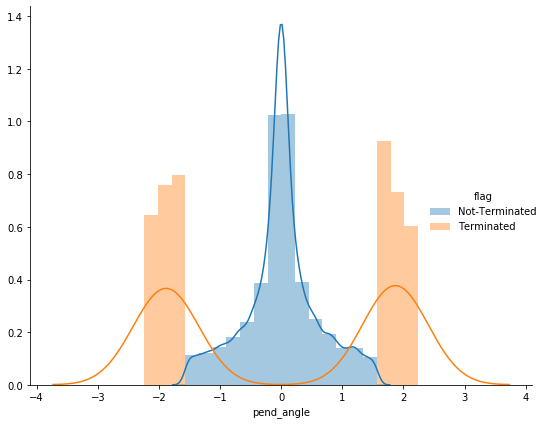

In [122]:
plot_distribution(obs_df, 'pend_angle')

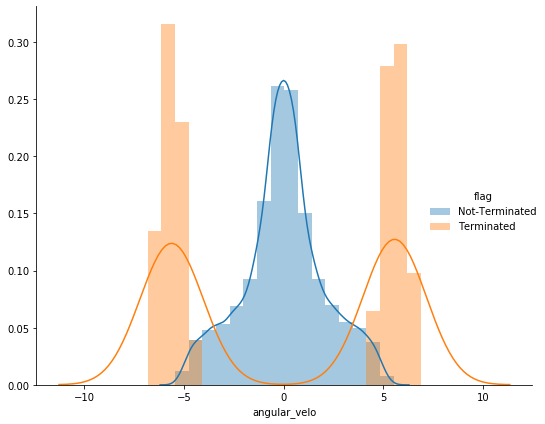

In [123]:
plot_distribution(obs_df, 'angular_velo')

- Here, we can see that the values at positive and negative extremes (tails) corresponds to terminal states

- Now, as mentioned at top, I create a separate (reduced) dataset which will exclude the 4 states that lead to terminal states
    - E.g., assume there is a sequence of states in the order (s1,s2,s3,s4,s5,s6,s7,s8,s9,TERMINAL-STATE, s11, s12, ...) stored in the original dataset, the new dataset will only include (s1,s2,s3,s4,s5,s11,s12,...)

In [103]:
episode_count = []
episodic_step = []

epi_step_count = 0
epi_count = 1

for idx, row in obs_df.iterrows():
    
    epi_step_count += 1   
        
    if row.flag == 'Terminated':
        episodic_step.append(epi_step_count)
        epi_step_count = 0
        
        episode_count.append(epi_count)
        epi_count +=1
        continue
        
    episode_count.append(epi_count)
    episodic_step.append(epi_step_count)
        
obs_df = pd.concat([obs_df
                    , pd.Series(episodic_step,name='episodic_step')
                    , pd.Series(episode_count ,name='episode_num')],axis=1)

In [104]:
obs_df.head(10)

,step,pend_angle,angular_velo,flag,episodic_step,episode_num
0,0,-0.093376,-0.802910,Not-Terminated,1,1
1,1,-0.260258,-1.668819,Not-Terminated,2,1
2,2,-0.456847,-1.965890,Not-Terminated,3,1
3,3,-0.719358,-2.625113,Not-Terminated,4,1
4,4,-1.120158,-4.007998,Not-Terminated,5,1
5,5,-1.666351,-5.461932,Terminated,6,1
6,6,0.018987,0.001175,Not-Terminated,1,2
7,7,0.100011,0.810234,Not-Terminated,2,2
8,8,0.264617,1.646056,Not-Terminated,3,2
9,9,0.434469,1.698523,Not-Terminated,4,2


In [109]:
# Identify number of steps to select from each episode (after removing 4 states leading to terminal state)
epi_n_epi_steps_fil_df = obs_df.groupby(['episode_num']).episodic_step.max().reset_index()
epi_n_epi_steps_fil_df.loc[:,'epi_steps_to_use'] = epi_n_epi_steps_fil_df.episodic_step.apply(lambda val: max(0,val-5))

obs_df = obs_df.merge(right = epi_n_epi_steps_fil_df.loc[:,['episode_num', 'epi_steps_to_use']]
                     , right_on='episode_num'
                     , left_on = 'episode_num'
                     , how = 'left')

obs_df.head(20)

In [111]:
# Empty list to store the selected rows for the reduced dataset
filter_df_rows = []

# Iterate over rows; only select the states/rows accoding to 'epi-steps-to-use' values
for idx, row in obs_df.iterrows():
    
    if row.episodic_step <= row.epi_steps_to_use:
        filter_df_rows.append(row)
    
obs_df_reduced = pd.concat(filter_df_rows,axis=1).T

In [119]:
obs_df_reduced.head(10)

,step,pend_angle,angular_velo,flag,episodic_step,episode_num,epi_steps_to_use
0,0,-0.093376,-0.80291,Not-Terminated,1,1,1
6,6,0.0189875,0.00117481,Not-Terminated,1,2,3
7,7,0.100011,0.810234,Not-Terminated,2,2,3
8,8,0.264617,1.64606,Not-Terminated,3,2,3
14,14,-0.0483389,-0.113406,Not-Terminated,1,3,3
15,15,-0.121194,-0.728556,Not-Terminated,2,3,3
16,16,-0.238057,-1.16862,Not-Terminated,3,3,3
22,22,0.0481257,0.204567,Not-Terminated,1,4,4
23,23,0.131228,0.831025,Not-Terminated,2,4,4
24,24,0.205988,0.747598,Not-Terminated,3,4,4


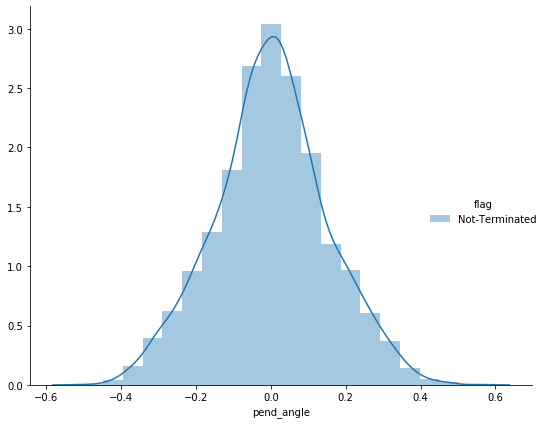

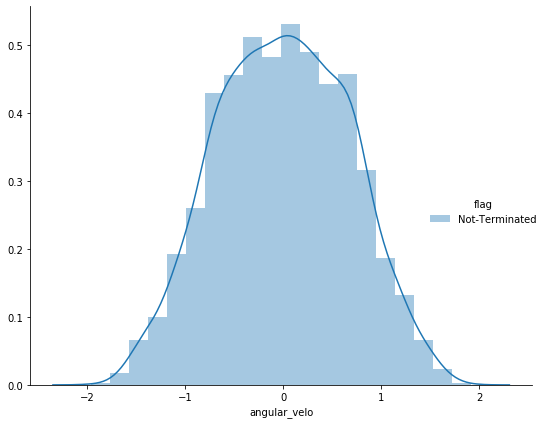

(None, None)

In [128]:
plot_distribution(obs_df_reduced, 'pend_angle'), plot_distribution(obs_df_reduced, 'angular_velo')

- We can see that the reduced dataset doesn't include any terminal states, and also the tails of the stata value distributions have been pruned

### Preparing different initial state groups